<a href="https://colab.research.google.com/github/Ajay-user/DataScience/blob/master/Logistic_Regression_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Import data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

The MNIST dataset is very popular machine learning dataset, consisting of 70000 grayscale images of handwritten digits, of dimensions 28x28.

In [3]:
print('training image set shape',x_train.shape)
print('training label set shape',y_train.shape)
print('testing image set shape',x_test.shape)
print('testing label set shape',y_test.shape)


training image set shape (60000, 28, 28)
training label set shape (60000,)
testing image set shape (10000, 28, 28)
testing label set shape (10000,)


## Preprocessing 

In [4]:
# adding channel info
x_train = x_train[..., tf.newaxis].astype('float32')
x_test = x_test[...,tf.newaxis].astype('float32')

print('training image set shape',x_train.shape)
print('testing image set shape',x_test.shape)

training image set shape (60000, 28, 28, 1)
testing image set shape (10000, 28, 28, 1)


### Use tf.data to batch and shuffle the dataset

In [5]:
# shuffling and batching
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(60000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)

print('training dataset ',train_ds.element_spec)
print('testing dataset', test_ds.element_spec)

training dataset  (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))
testing dataset (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))


## Visualize the training data

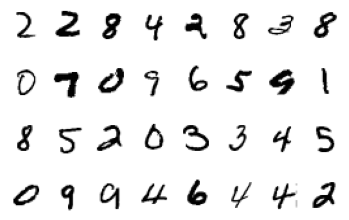

In [6]:
images , labels = next(iter(train_ds))
index = 0
for image in images:
  index +=1
  plt.subplot(4,8,index)
  plt.imshow(image.numpy().reshape(28,28), cmap=plt.cm.binary)
  plt.axis('off')

While our data inputs (which we'll call x) are images (i.e. 2-dimensional), MNIST digits are pretty small, and the model we're using is very simple.

Thus, we're going to be treating the input as flat vectors.

we can use tf.reshape for accomplishing this 

In [7]:
# input data
x = tf.reshape(images, shape=[-1, 28*28])
print('shape of input ',x.shape)

shape of input  (32, 784)



To get our predicted probabilities of each digit, let's first start with the probability of a digit for eg: let digit = 1

 For our simple model, we can start by applying a linear transformation.
 
 That is, we multiply each pixel $x_i$ of the input row vector by a weight $w_{i,1}$, sum them all together, and then add a bias $b_1$. This is equivalent to a dot product between the class "1" weights and the input:

$$\begin{align}
y_1 = \sum_i x_i w_{i,1} + b_1
\end{align}$$

The magnitude of this result $y_1$, we'll take as being correlated to our belief in how likely we think the input digit was a 1. The higher the value of $y_1$, the more likely we think the input image $x$ was a 1 (i.e., we'd hope we'd get a relatively large value for $y_1$ for the above image). Remember though, our original goal was to identify all 10 digits, so we actually have:

$$\begin{align*}
y_0 = \sum_i x_i w_{i,0} + b_0 \\
y_1 = \sum_i x_i w_{i,1} + b_1 \\
y_2 = \sum_i x_i w_{i,2} + b_2 \\
y_3 = \sum_i x_i w_{i,3} + b_3 \\
y_4 = \sum_i x_i w_{i,4} + b_4 \\
y_5 = \sum_i x_i w_{i,5} + b_5 \\
y_6 = \sum_i x_i w_{i,6} + b_6 \\
y_7 = \sum_i x_i w_{i,7} + b_7 \\
y_8 = \sum_i x_i w_{i,8} + b_8 \\
y_9 = \sum_i x_i w_{i,9} + b_9
\end{align*}$$
We can express this in matrix form as:

$$\begin{align}
y = x W + b 
\end{align}$$
To take advantage of parallel computation, we commonly process multiple inputs $x$ at once, in a minibatch. We can stack each input $x$ into a matrix $X$, giving us

$$\begin{align}
Y = X W + b 
\end{align}$$

In our specific example, the minibatch size $m$ is $32$, the dimension of the data is $28 \times 28=784$, and the number of classes $c$ is $10$. While $X$ and $Y$ are matrices due to the batching, conventionally, they are often given lowercase variable names, as if they were for a single example. We will use x and y throughout.



`The weight 𝑊 and bias 𝑏 make up the parameters of this model. When we say that we want to "learn the model," what we're really trying to do is find good values for every element in 𝑊 and 𝑏 . Before we begin learning, we need to initialize our parameters to some value, as a starting point. Here, we don't really know what the best values are, so we going to initialize 𝑊 randomly (using something called glorot initialization), and set 𝑏 to a vector of zeros.`

## Weight and bias

In [8]:
# Randomly initialize weights W
initializer = tf.keras.initializers.GlorotUniform()
values = initializer(shape=(784,10))
W = tf.Variable(initial_value=values, trainable=True, name='Weight matrix')
W

<tf.Variable 'Weight matrix:0' shape=(784, 10) dtype=float32, numpy=
array([[-0.07497184, -0.0104222 , -0.05938705, ..., -0.05212446,
        -0.01464131,  0.0158154 ],
       [ 0.01998486, -0.04123537,  0.00597461, ...,  0.02336224,
         0.0230143 , -0.08053989],
       [-0.02881853, -0.00373884, -0.00394925, ...,  0.05332046,
         0.05392396,  0.07506866],
       ...,
       [-0.06237372,  0.01338241,  0.05482716, ...,  0.00322207,
        -0.06408623,  0.02508795],
       [-0.08154108, -0.00711457,  0.07368211, ...,  0.05013929,
         0.06218601,  0.01826372],
       [ 0.03182149,  0.0503198 , -0.0795769 , ...,  0.01782169,
        -0.05829192, -0.07600254]], dtype=float32)>

In [9]:
# Initialize bias b as 0s
b = tf.Variable(initial_value=tf.zeros(shape=[10]), trainable=True, name='Bias')
b

<tf.Variable 'Bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [10]:
# Linear transformation with W and b

y = tf.matmul(x, W) + b

In [11]:
print('shape of linear transformation ',y.shape)

shape of linear transformation  (32, 10)



We can see for example what the predictions look like for the first example in our minibatch. Remember, the bigger the number, the more the model thinks the input $x$ is of that class.

In [12]:
print('output for first sample in the batch', y[0,:])

output for first sample in the batch tf.Tensor(
[ 176.26572   105.57518  -104.07212    42.281826 -107.02426   -14.817807
  -85.78006    21.707232  -34.027843 -172.88087 ], shape=(10,), dtype=float32)


We can interpret these values (aka logits) 𝑦 as probabilities if we normalize them to be positive and add up to 1. In logistic regression, we do this with a softmax:

$$\begin{align}
p(y_i) = \text{softmax}(y_i) = \frac{\text{exp}(y_i)}{\sum_j\text{exp}(y_j)}
\end{align}$$
Notice that because the range of the exponential function is always non-negative, and since we're normalizing by the sum, the softmax achieves the desired property of producing values between 0 and 1 that sum to 1. If we look at the case with only 2 classes, we see that the softmax is the multi-class extension of the binary sigmoid function:

In [13]:
print('output probablity scores for the first sample is', tf.nn.softmax(y[0,:]))
print('Model predict class label ', tf.argmax(tf.nn.softmax(y[0,:])).numpy())
print('Actual class label',labels[0].numpy())

output probablity scores for the first sample is tf.Tensor(
[1.000000e+00 1.992921e-31 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00], shape=(10,), dtype=float32)
Model predict class label  0
Actual class label 2



We've now defined the forward pass of our model: given an input image, the graph returns the probabilities the model thinks the input is each of the 10 classes. Are we done?

No !!!

## The cross-entropy loss
We don't know the values of $W$ and $b$ yet!

Remember how we initialized them randomly?

Before we adjust any of the weights, we need a way to measure how the model is doing.

Specifically, we're going to measure how badly the model is doing. We do this with a loss function, which takes the model's prediction and returns a single number (i.e. a scalar) summarizing model performance. This loss will inform how we adjust the parameters of the model.

The loss we commonly use in classification is cross-entropy, a concept from information theory.

Cross-entropy - a way of quantifying how far apart one distribution $y'$ is from another $y$.

$$\begin{align}
H_{y'}(y)=-\sum_i y'_i \text{log}(y_i)
\end{align}$$
In our case, $y$ is the set of probabilities predicted by the model and  $y'$ is the target distribution.

What is the target distribution?

It's the true label, which is what we wanted the model to predict.

Cross-entropy not only captures how correct (max probability corresponds to the right answer) the model's answers are, it also accounts for how confident (high confidence in correct answers) they are. This encourages the model to produce very high probabilities for correct answers while driving down the probabilities for the wrong answers, instead of merely being satisfied with it being the argmax.

In [14]:
# loss-function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

cross_entropy_loss = loss_fn(y_true=labels, y_pred=y)

print('cross entropy loss', cross_entropy_loss.numpy())

cross entropy loss 242.80344



## The backwards pass : backpropagation
Now that we have the loss as a way of quantifying how badly the model is doing, we can improve our model by changing the parameters in a way that minimizes the loss. For neural networks, the common way of doing this is with backpropagation: we take the gradient of the loss with respect to $W$ and $b$ and take a step in the direction that reduces our loss.

First, we need to create an optimizer. There are many choices, but since logistic regression is fairly simple, we'll use standard stochastic gradient descent (SGD), which makes the following update:

$$\begin{align}
\theta_{t+1} = \theta_t - \alpha \nabla_\theta \mathcal{L}
\end{align}$$
where $\theta$ is a parameter, $\alpha$ is our learning rate (step size), and $\nabla_\theta \mathcal{L}$ is the gradient of our loss with respect to $\theta$.

In [15]:
with tf.GradientTape() as tape:
  y = tf.matmul(x, W) + b
  loss = loss_fn(y_true=labels, y_pred=y)
gradient = tape.gradient(loss,[W,b])
gradient

[<tf.Tensor: shape=(784, 10), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([ 8.4824860e-06,  5.8335471e-01, -1.5625000e-01, -8.4039219e-02,
        -1.2500849e-01,  3.1531639e-02, -3.0877644e-02,  3.1280495e-02,
        -1.2500000e-01, -1.2500000e-01], dtype=float32)>]

In [16]:
# optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

optimizer.apply_gradients(zip(gradient,[W,b]))


<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [17]:
# weights after applying gradients
W

<tf.Variable 'Weight matrix:0' shape=(784, 10) dtype=float32, numpy=
array([[-0.07497184, -0.0104222 , -0.05938705, ..., -0.05212446,
        -0.01464131,  0.0158154 ],
       [ 0.01998486, -0.04123537,  0.00597461, ...,  0.02336224,
         0.0230143 , -0.08053989],
       [-0.02881853, -0.00373884, -0.00394925, ...,  0.05332046,
         0.05392396,  0.07506866],
       ...,
       [-0.06237372,  0.01338241,  0.05482716, ...,  0.00322207,
        -0.06408623,  0.02508795],
       [-0.08154108, -0.00711457,  0.07368211, ...,  0.05013929,
         0.06218601,  0.01826372],
       [ 0.03182149,  0.0503198 , -0.0795769 , ...,  0.01782169,
        -0.05829192, -0.07600254]], dtype=float32)>

In [18]:
# bias after applying gradients
b

<tf.Variable 'Bias:0' shape=(10,) dtype=float32, numpy=
array([-8.4824859e-07, -5.8335472e-02,  1.5625000e-02,  8.4039224e-03,
        1.2500850e-02, -3.1531639e-03,  3.0877644e-03, -3.1280497e-03,
        1.2500000e-02,  1.2500000e-02], dtype=float32)>

We've now successfully trained on a minibatch! However, one minibatch probably isn't enough. At this point, we've trained the model on 100 examples out of the 60000 in the training set. We're going to need to repeat this process, for more of the data.


## Model Training
To train the model, we just need repeat what we just did for more minibatches from the training set. As a recap, the steps were:

* Draw a minibatch
* Perform the forward pass (compute prediction, calculate loss)
* Perform the backward pass (compute gradients, perform SGD step)

Going through the entire dataset once is referred to as an epoch. In many cases, we train neural networks for multiple epochs, but here, a single epoch is enough.

In [19]:
from tqdm.notebook import tqdm

for images, labels in tqdm(train_ds):

  # flatten the input
  x = tf.reshape(images, shape=[-1,28*28])
  
  with tf.GradientTape() as tape:
    # forward pass
    y = tf.matmul(x, W) + b
    # compute the loss
    loss = loss_fn(labels, y)
  
  # backward pass
  gradient = tape.gradient(loss, [W,b])
  optimizer.apply_gradients(zip(gradient,[W,b]))

  

Now let's see how we did! For every image in our test set, we run the data through the model, and take the digit in which we have the highest confidence as our answer. We then compute an accuracy by seeing how many we got correct.

In [23]:
correct = 0
total = len(x_test)

for images, labels in tqdm(test_ds):
  # flatten the image
  x = tf.reshape(images, shape=[-1,28*28])
  # forward-pass
  y = tf.matmul(x, W)+b

  predictions = tf.argmax(y, axis=1)

  correct += np.sum(predictions==labels.numpy())

print('Test Accuracy is',correct/total)


Test Accuracy is 0.8945



Not bad for a simple model and a few lines of code. Before we conclude this example, there's one more interesting thing we can do. Normally, it can be difficult to inspect exactly what the filters in a model are doing, but since this model is so simple, and the weights transform the data directly to their logits, we can actually visualize what the model's learning by simply plotting the weights. The results look pretty reasonable:

## Visualize learning

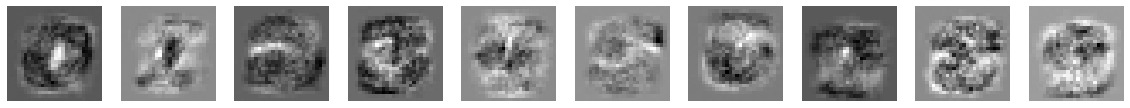

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(20,2))

for digit in range(10):
  img = tf.reshape(W[:,digit],shape=[28,28])
  ax[digit].imshow(img, cmap=plt.cm.binary)
  ax[digit].axis('off')

## Object-oriented Refactorization

Most of the time, we do find ourselves repeating the same fairly standard lines of code, which can slow us down. Worse, it clutters up our code unnecessarily and introduces room for bugs and typos. And finally, as researchers or engineers, we would like to spend most of our time thinking on the highest levels of abstractions: I want to add a convolution layer here, then a fully-connected there, etc. Having to code all the small details are distractions that can detract from our ability to translate ideas into code. For this reason,Tensorflow has higher level abstractions to help speed up implementation and improve model organization. 
 


In [54]:
class ForwardPass:
  def __init__(self, in_dim, out_dim):
    initializer = tf.initializers.glorot_uniform(seed=0)
    values = initializer(shape=(in_dim, out_dim))
    self.weights = tf.Variable(initial_value=values, trainable=True, name='Weight matrix', dtype='float32')
    self.bias = tf.Variable(initial_value=tf.zeros(shape=(out_dim)), name='Bias', dtype='float32')
  
  def forward(self, x):
    return tf.matmul(x, self.weights)+self.bias



In [55]:
linear = ForwardPass(784,10)

print('Shape of Weight matrix', linear.weights.shape)
print('Shape of bias',linear.bias.shape)

Shape of Weight matrix (784, 10)
Shape of bias (10,)


In [56]:
# test with a random input
random_input = tf.random.uniform(shape=(1, 784))

y = linear.forward(random_input)
print('Output shape ',y.shape)

Output shape  (1, 10)


**Object-oriented Refactorization**

It often makes sense for us to code our models in an object-oriented manner. To understand why, let's look back at the linear transformation $y = xW + b$ that we used for logistic regression. We can see that while the operation consisted of a matrix multiplication and addition, also associated with this operation was the instantiation of two parameters W and b, and these two parameters conceptually belong to the transform. As such, it would make sense to bundle up the instantiation of the two parameters with the actual transformation:

In [122]:
class MnistModel:
  def __init__(self, in_dim, out_dim):
    initializer = tf.initializers.glorot_uniform(seed=0)
    values = initializer(shape=(in_dim, out_dim))
    self.weights = tf.Variable(initial_value=values, trainable=True, name='Weight matrix', dtype='float32')
    self.bias = tf.Variable(initial_value=tf.zeros(shape=(out_dim)), name='Bias', dtype='float32')

  def forward(self, x):
    y = tf.matmul(x, self.weights)+self.bias
    return y

In [123]:
# initialize the model
model = MnistModel(784,10)

print('Weight matrix',model.weights)
print('Bias',model.bias)

Weight matrix <tf.Variable 'Weight matrix:0' shape=(784, 10) dtype=float32, numpy=
array([[-0.05024235,  0.03581654,  0.0521685 , ..., -0.05268933,
         0.0607236 ,  0.00698493],
       [-0.06326963, -0.06759664,  0.04295988, ..., -0.05020069,
        -0.04909785, -0.05931706],
       [-0.05842348,  0.08647356, -0.01511052, ..., -0.05360998,
        -0.07873911,  0.03152344],
       ...,
       [ 0.00217336,  0.00802324, -0.03122882, ...,  0.05058137,
         0.07929847, -0.00046643],
       [ 0.00296357,  0.02763945,  0.02533332, ...,  0.02024429,
         0.0655615 , -0.03219784],
       [-0.07119273, -0.07016047, -0.08450471, ..., -0.06330177,
        -0.04424631, -0.08362049]], dtype=float32)>
Bias <tf.Variable 'Bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>


In [124]:
# loss function and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

In [125]:
# training the model just for one epoch

for images, labels in tqdm(train_ds):
  # flatten the image
  x = tf.reshape(images, shape=[-1,28*28])
  # forward-pass
  with tf.GradientTape() as tape:
    y = model.forward(x)
    # loss
    loss = loss_fn(labels, y)
  # compute the gradients
  gradient = tape.gradient(loss,[model.weights, model.bias])
  # update model parameters
  optimizer.apply_gradients(zip(gradient,[model.weights,model.bias]))


In [127]:
# testing the model
correct = 0
total = len(x_test)

for images, labels in tqdm(test_ds):
  # flatten the image
  x = tf.reshape(images, shape=[-1,28*28])
  # forward-pass
  y = model.forward(x)
  # model prediction
  predictions = tf.argmax(y, axis=1)
  correct += np.sum(predictions==labels.numpy())

print('Test Accuracy',correct/total)





Test Accuracy 0.8679


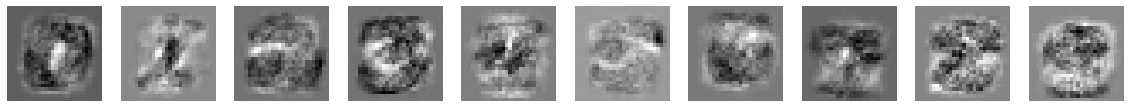

In [128]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(20,2))

# weight matrix
W = model.weights

for digit in range(10):
  img = tf.reshape(W[:,digit],shape=[28,28])
  ax[digit].imshow(img, cmap=plt.cm.binary)
  ax[digit].axis('off')